In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms

columns = ["filename", "classname"]

BASE = "./data"
# BASE = "/content/drive/MyDrive/Colab Notebooks/data/preprocessed"
data_csv_file = os.path.join(BASE, "./data.csv")
data_folder = os.path.join(BASE, "./images")
root_folder = os.path.join(BASE, "./")

data_df = pd.read_csv(data_csv_file, skiprows=1, names=columns)

In [4]:
# get image data
def getImageData(folder, image_file):
    return Image.open(os.path.join(folder, image_file)).convert('RGB') # Load the image

# create directory
def make_dir(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)

model_path = os.path.join(root_folder, 'model', 'face_mask_detection.pth')
# make_dir(model_path)

# predefined classes
classes = {
    "mask_colorful": 0,
    "face_no_mask": 1,
    "mask_surgical": 2,
    "ffp2_mask": 3
}


In [5]:
class FaceMaskDataset(Dataset):
    dataset = []
    conversion = None

    def __init__(self, indexes, conversion=transforms.ToTensor()):
        self.conversion = conversion
        for rowIndex in indexes:
            sample = {}
            sample['image'] = getImageData(data_folder, data_df[columns[0]][rowIndex])
            sample['target'] = classes[data_df[columns[1]][rowIndex]]
            self.dataset.append(sample)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        if self.conversion is not None:
            image = self.conversion(image)
        return image, self.dataset[index]['target']

In [6]:
train_split_percentage = 0.75
val_split_percentage = 0.15
test_split_percentage = 0.1
size_of_the_dataset = int(data_df.shape[0])


print("size_of_the_dataset", size_of_the_dataset)

batch_size = 25
num_of_classes = len(classes.keys())

indexes = list(range(size_of_the_dataset))
random.shuffle(indexes)


train_indexes = indexes[:int(train_split_percentage*len(indexes))]
val_indexes = indexes[int(train_split_percentage*len(indexes))                      :int((train_split_percentage + val_split_percentage)*len(indexes))]
test_indexes = indexes[int(
    (train_split_percentage + val_split_percentage)*len(indexes)):]


print(f"Effective train split = {len(train_indexes)/len(indexes)*100}%")
print(f"Effective val split = {len(val_indexes)/len(indexes)*100}%")
print(f"Effective test split = {len(test_indexes)/len(indexes)*100}%")

size_of_the_dataset 1333
Effective train split = 74.94373593398349%
Effective val split = 15.003750937734434%
Effective test split = 10.05251312828207%


In [7]:
transform = transforms.Compose(
    [transforms.Resize((250, 250)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])])

In [8]:
print("Loading training set")
train_dataset = FaceMaskDataset(train_indexes, conversion=transform)
print("Loading validation set")
val_dataset = FaceMaskDataset(val_indexes, conversion=transform)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Loading training set
Loading validation set


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class FaceMaskClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
class CNN(FaceMaskClassificationBase):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(246016, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, num_of_classes),
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            images, labels = batch
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            loss = model.training_step(batch)
            # update-training-loss
            train_losses.append(loss)
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [13]:
model = CNN()
model = model.to(device)

In [17]:
history = fit(50, 0.001, model, train_loader, val_loader, torch.optim.Adam)

torch.save(model, model_path)

Epoch [1], train_loss: 15.0505, val_loss: 1.2846, val_acc: 0.3876
Epoch [2], train_loss: 1.3070, val_loss: 1.1906, val_acc: 0.4562
Epoch [3], train_loss: 1.2435, val_loss: 1.0950, val_acc: 0.5312
Epoch [4], train_loss: 1.1679, val_loss: 1.0612, val_acc: 0.5336
Epoch [5], train_loss: 1.1380, val_loss: 0.9806, val_acc: 0.5788
Epoch [6], train_loss: 1.0268, val_loss: 0.8878, val_acc: 0.6162
Epoch [7], train_loss: 0.9163, val_loss: 0.7731, val_acc: 0.6754
Epoch [8], train_loss: 0.9211, val_loss: 0.6946, val_acc: 0.7246
Epoch [9], train_loss: 0.6914, val_loss: 1.4701, val_acc: 0.5489
Epoch [10], train_loss: 0.6541, val_loss: 0.4591, val_acc: 0.8382
Epoch [11], train_loss: 0.5313, val_loss: 0.3292, val_acc: 0.8882
Epoch [12], train_loss: 0.4119, val_loss: 0.2786, val_acc: 0.9057
Epoch [13], train_loss: 0.3344, val_loss: 0.2258, val_acc: 0.9233
Epoch [14], train_loss: 0.2599, val_loss: 0.1481, val_acc: 0.9475
Epoch [15], train_loss: 0.2063, val_loss: 0.1523, val_acc: 0.9466
Epoch [16], train_

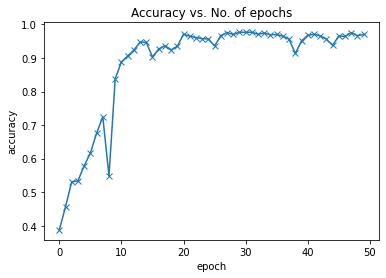

In [18]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

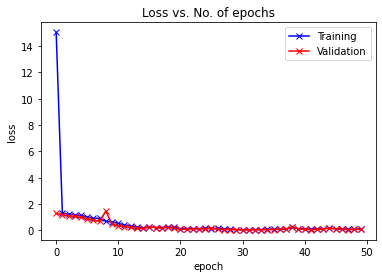

In [19]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [16]:
model.load_state_dict(torch.load(model_path, device), strict=False)
model.eval()

AttributeError: ignored

In [20]:
test_dataset = FaceMaskDataset(test_indexes, conversion=transform)
print("Loading test set")
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Loading test set


Test Accuracy of the model: 90.69767441860465 %


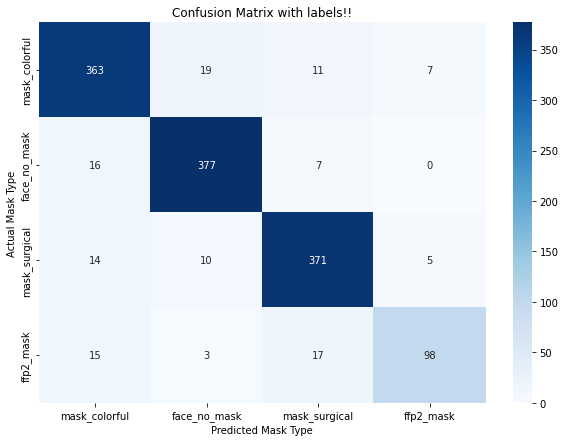

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       400
         1.0       0.92      0.94      0.93       400
         2.0       0.91      0.93      0.92       400
         3.0       0.89      0.74      0.81       133

    accuracy                           0.91      1333
   macro avg       0.90      0.88      0.89      1333
weighted avg       0.91      0.91      0.91      1333



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = torch.tensor([])
y_true = y_true.to(device)
y_preds = torch.tensor([])
y_preds = y_preds.to(device)

# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_true = torch.cat(
            (y_true, labels)
        )
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_preds = torch.cat(
            (y_preds, predicted)
        )
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))


y_true = y_true.to('cpu')
y_preds = y_preds.to('cpu')
matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize = (10,7))
ax = sns.heatmap(matrix, fmt='', annot=True, cmap='Blues')
ax.set_title('Confusion Matrix with labels!!');
ax.set_xlabel('Predicted Mask Type')
ax.set_ylabel('Actual Mask Type')
ax.xaxis.set_ticklabels([i for i in classes.keys()])
ax.yaxis.set_ticklabels([i for i in classes.keys()])
plt.show()

from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_true, y_preds)
print(classification_report(y_true,y_preds))

In [ ]:
def label_to_classname(label):
  for classname in classes.keys():
    if classes[classname] == label:
      return classname
  return 'NULL'

In [ ]:
new_images_path = os.path.join(root_folder, "./test")

new_images = os.listdir(new_images_path)

with torch.no_grad():
    for image in new_images:
      file_name = image
      image = transform(Image.open(os.path.join(new_images_path, image)).convert('RGB'))
      # image = image.unsqueeze(1)
      image = image.unsqueeze(0)
      image = image.to(device)
      labels = model(image)
      _, predicted = torch.max(labels.data, 1)
      print(f'{file_name} file is {label_to_classname(predicted[0])}')


1.jpg file is mask_surgical
0748.jpg file is face_no_mask
4.jpg file is mask_surgical
3.png file is ffp2_mask


In [ ]:
# transform = transforms.Compose(
#     [transforms.Resize((100, 100)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# new_data_folder = "./data/new/images"

# tensor_image = transforms.ToPILImage()(transform(Image.open(os.path.join(new_data_folder, '1.png'))))

# import matplotlib.pyplot as plt

# plt.imshow(tensor_image)
# plt.show()